In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb

# ----------------- Step 1: Load and Preprocess Data -----------------
file_path = "scaled_data.csv"
df = pd.read_csv(file_path)

# Ensure 'Date' column is removed if present
if "Date" in df.columns:
    df.drop(columns=["Date"], inplace=True)

# Define target column
target_col = "Close"

# Ensure all columns are numeric
df = df.apply(pd.to_numeric, errors="coerce")
df.dropna(inplace=True)

# Split into features (X) and target (y)
X = df.drop(columns=[target_col])  # Features
y = df[target_col].astype(np.float32).values.reshape(-1, 1)  # Target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Reshape X for LSTM (LSTM expects 3D: [samples, timesteps, features])
X_train_lstm = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_lstm = X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1])

# ----------------- Step 2: Build and Train LSTM Model -----------------
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization, Bidirectional, Add

# Define input
input_layer = Input(shape=(1, X_train.shape[1]))

# First Bidirectional LSTM layer (captures past and future dependencies)
x = Bidirectional(LSTM(128, activation='relu', return_sequences=True))(input_layer)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Second LSTM layer
x = LSTM(128, activation='relu', return_sequences=True)(x)  # Match units to 128
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Save residual connection before last LSTM layer
residual = x  

# Third LSTM layer (now also 128 units)
x = LSTM(128, activation='relu', return_sequences=False)(x)  # Match residual shape
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Residual Connection (adding features)
x = Add()([x, residual[:, -1, :]])  # Now both are (batch_size, 128)

# Fully connected layers
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Dense(32, activation='relu')(x)

# Output layer
output_layer = Dense(1)(x)

# Build model
lstm_model = Model(inputs=input_layer, outputs=output_layer)

# Compile model
lstm_model.compile(optimizer='adam', loss='mse')

# Train model
lstm_model.fit(X_train_lstm, y_train, epochs=150, batch_size=32, validation_data=(X_test_lstm, y_test), verbose=1)


# ----------------- Step 3: Extract LSTM Features -----------------
_ = lstm_model.predict(X_train_lstm[:1])

# Extract features from the second-to-last layer (Dense 32)
lstm_feature_extractor = Model(inputs=lstm_model.input, outputs=lstm_model.layers[-2].output)

X_train_lstm_features = lstm_feature_extractor.predict(X_train_lstm)
X_test_lstm_features = lstm_feature_extractor.predict(X_test_lstm)

print("✅ LSTM Feature Extraction Complete!")

# ----------------- Step 4: Train XGBoost Regressor -----------------
xgb_model = xgb.XGBRegressor(
    objective="reg:squarederror", 
    n_estimators=100, 
    learning_rate=0.05, 
    max_depth=6
)

xgb_model.fit(X_train_lstm_features, y_train)

# Predict using XGBoost
y_pred_xgb = xgb_model.predict(X_test_lstm_features)

# ----------------- Step 5: Evaluate Model -----------------
mae = mean_absolute_error(y_test, y_pred_xgb)
mse = mean_squared_error(y_test, y_pred_xgb)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_xgb)

print(f"🔹 Mean Absolute Error (MAE): {mae:.4f}")
print(f"🔹 Mean Squared Error (MSE): {mse:.4f}")
print(f"🔹 Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"🔹 R² Score: {r2:.4f}")

print("🚀 XGBoost Model Training & Evaluation Complete!")


Epoch 1/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 27s 103ms/step - loss: 347626432.0000 - val_loss: 383672896.0000
Epoch 2/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 370829248.0000 - val_loss: 383664992.0000
Epoch 3/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 369799872.0000 - val_loss: 383665568.0000
Epoch 4/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 381444608.0000 - val_loss: 383646816.0000
Epoch 5/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 375087200.0000 - val_loss: 383610816.0000
Epoch 6/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 375711520.0000 - val_loss: 383572160.0000
Epoch 7/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 367672096.0000 - val_loss: 383019648.0000
Epoch 8/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 372230144.0000 - val_loss: 381495008.0000
Epoch 9/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 358448992.0000 - val_loss: 379139264.0000
Epoch 10/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 377262432.0000 - va

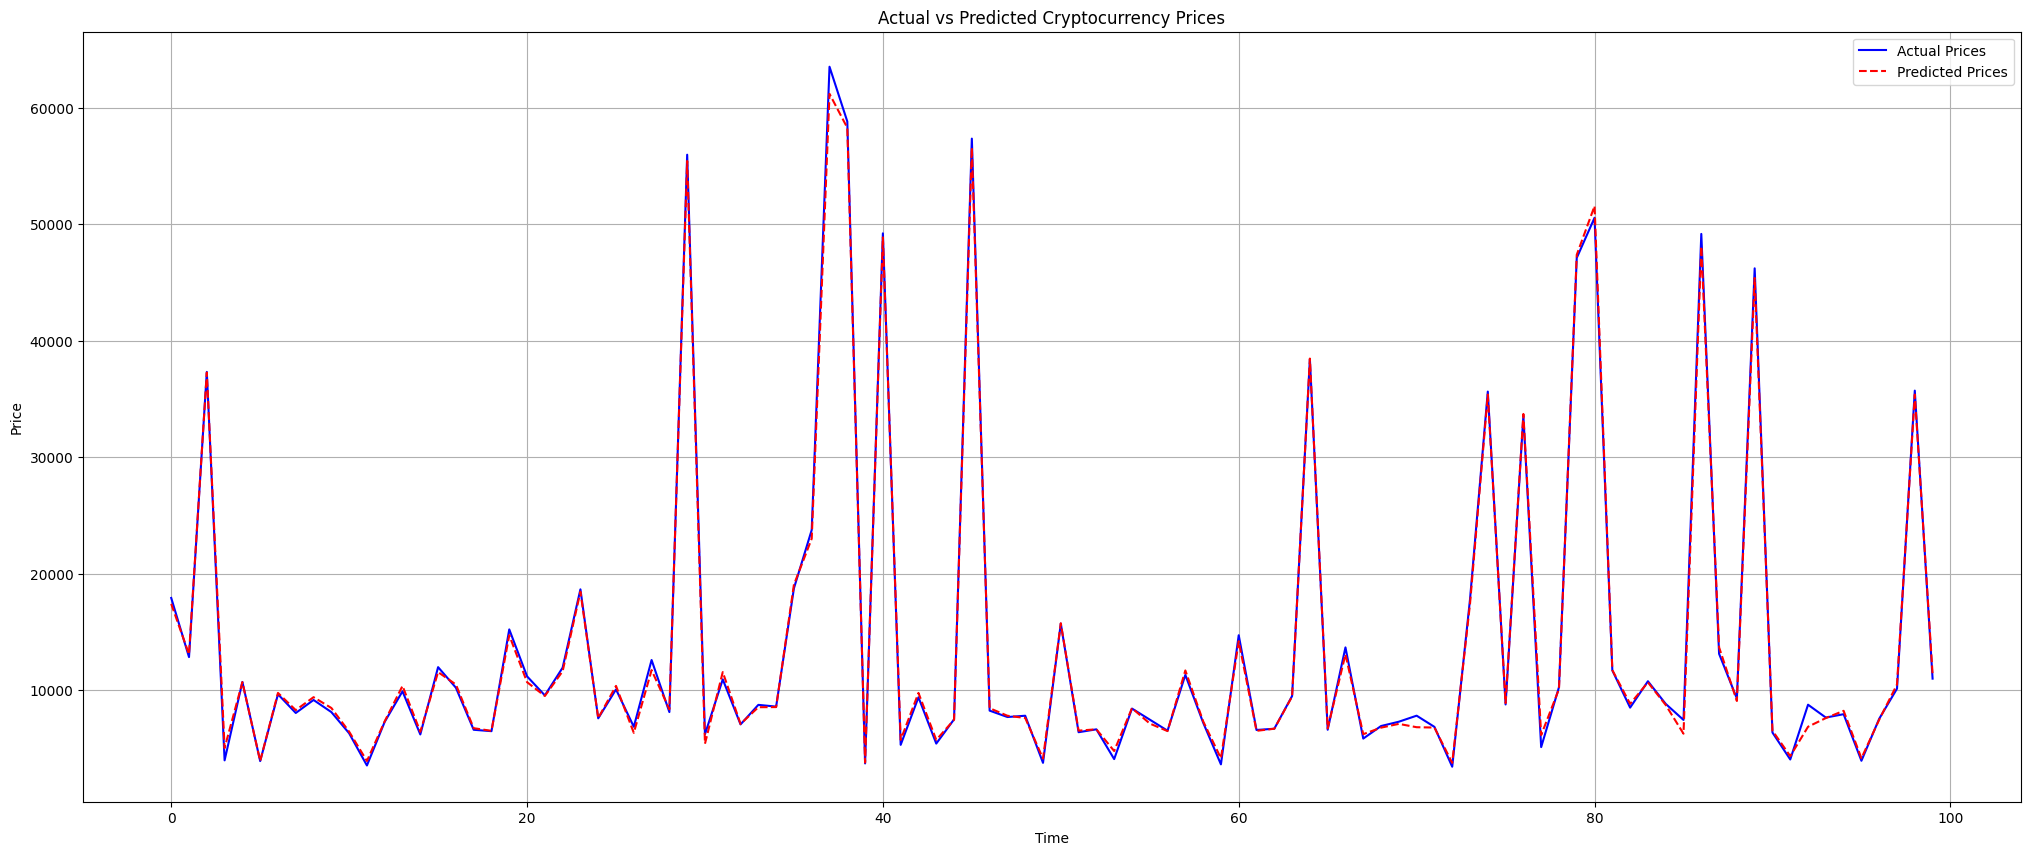

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Plot actual vs. predicted values
plt.figure(figsize=(25, 10))
plt.plot(y_test[0:100], label="Actual Prices", color="blue", linestyle="-")
plt.plot(y_pred_xgb[0:100], label="Predicted Prices", color="red", linestyle="dashed")

# Add title and labels
plt.title("Actual vs Predicted Cryptocurrency Prices")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()
